# Main Notebook

File to perform experiments

## Imports

In [1]:
import os
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import pandas as pd
import time
from tqdm import tqdm
import tensorflow as tf

from models.GaussianProcess import GaussianProcess
from acquisition_functions.UseMO import usemo_acq
from acquisition_functions.MES import mes_acq, basic_mes_acq
from acquisition_functions.PESMO import pesmo_acq
from acquisition_functions.MESMO import mesmo_acq
from arguments.arguments import MainArguments

from MOObenchmark import MOOackley, MOOexponential, MOOquadratic_ackley, MOOnnHousesRegression
from utils.calc_pareto import get_pareto_undominated_by, getSetfromFront

from models.MOOEvaluationProblem import MOOEvaluationProblem

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_termination
from pymoo.optimize import minimize

2023-01-30 22:24:36.829482: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 22:24:36.829856: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 22:24:36.855527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 22:24:36.855925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 22:24:36.856261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

## Algorithm Arguments

In [2]:
d = 1 # input dimensions
    
seed = 1
np.random.seed(seed)

## iterations of the main algorithm
total_iter = 40
## iterations taken randomly at the beggining
initial_iter = 1

## bound of the inputs definition
### with the current implementations all the input dimensions must have the same bounds, 
### but this can be changed
lower_bound = 0.0000000001
upper_bound = 0.5

lowerBounds = [lower_bound]*d
upperBounds = [upper_bound]*d


## Evaluation

In [4]:
## Evaluation function definition
O = 2
C = 0

def evaluation(x):
    return MOOnnHousesRegression(x)

This cell below gets the real pareto in two ways: with a grid and with a cheap optimizer (genetic algorithm) and plots both of them. These results are used in test problems as the actual pareto front. Although, to obtain these paretos many evaluations of the function are needed, so it has no sense running it in a costly black box problem.

In addition this is only prepared to plot a d=1, O=2 problem. We could visualize any problem, but the visualization get a lot more abstract and more plots are needed. If this is interesting I could do it.

Therefore I set the code below as text.

N = 1_001
X = np.linspace(lower_bound,upper_bound,N)
Z = np.zeros((N,2))

problem = MOOEvaluationProblem(evaluation, O=O, d=d, lowerBounds=lower_bound, upperBounds=upper_bound)
algorithm = NSGA2()
res = minimize( problem, 
                algorithm,
                termination = get_termination("n_gen",100))

real_pareto = res.F[np.argsort(res.F[:,0])]

for i in range(N):
    Z[i]=evaluation(X[i])

fig, axs = plt.subplots(1,3, figsize=(15,4))

axs[0].plot(X, Z[:,0], 'b')
axs[0].plot(X, Z[:,1], 'k')
axs[0].plot(res.X, res.F[:,0], 'xr', markersize=5)
axs[0].plot(res.X, res.F[:,1], 'xr', markersize=5)

axs[1].plot(np.reshape(Z,(-1,2))[:,0], np.reshape(Z,(-1,2))[:,1], 'kx')
axs[1].plot(res.F[:,0], res.F[:,1], 'rx')
res
axs[2].plot(res.F[:,0], res.F[:,1], 'x')
plt.show()

In [5]:
def random_acq(GP: GaussianProcess, **kwargs):
    while True:
        x_rand = np.random.uniform(GP.lowerBounds, GP.upperBounds, GP.d)
        if GP.X is None or not x_rand in GP.X:
            break
    return x_rand, 0

## N experiments

C = [0.208511]
Epoch 1/6


2023-01-30 22:24:53.422350: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


517/517 [==============================] - 1s 2ms/step - loss: 22980589568.0000 - mae: 210956.4375 - mse: 110211817472.0000 - val_loss: 13168445440.0000 - val_mae: 158162.4062 - val_mse: 63153926144.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 12750599168.0000 - mae: 163696.3594 - mse: 61149925376.0000 - val_loss: 12764071936.0000 - val_mae: 157166.1250 - val_mse: 61214588928.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 12218150912.0000 - mae: 160698.4219 - mse: 58596364288.0000 - val_loss: 11298532352.0000 - val_mae: 153790.1719 - val_mse: 54185996288.0000
Epoch 4/6
517/517 [==============================] - 1s 1ms/step - loss: 11846784000.0000 - mae: 158684.9844 - mse: 56815308800.0000 - val_loss: 11721648128.0000 - val_mae: 160590.6406 - val_mse: 56215195648.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 11919607808.0000 - mae: 158744.6250 - mse: 57164599296.0000 - val_loss: 12968299520.

2023-01-30 22:24:58.857788: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


C = [0.20851177]
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 22669545472.0000 - mae: 209449.8750 - mse: 108719595520.0000 - val_loss: 13100483584.0000 - val_mae: 158642.7188 - val_mse: 62827765760.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 12750650368.0000 - mae: 163832.6250 - mse: 61150015488.0000 - val_loss: 12770499584.0000 - val_mae: 156799.8281 - val_mse: 61245210624.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 12201212928.0000 - mae: 160284.3594 - mse: 58514915328.0000 - val_loss: 11263520768.0000 - val_mae: 153024.5000 - val_mse: 54017916928.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 11819567104.0000 - mae: 158354.6875 - mse: 56684601344.0000 - val_loss: 11709062144.0000 - val_mae: 160615.4531 - val_mse: 56154640384.0000
Epoch 5/6
517/517 [==============================] - 1s 1ms/step - loss: 11922947072.0000 - mae: 158652.6094 - mse: 57180422144.00

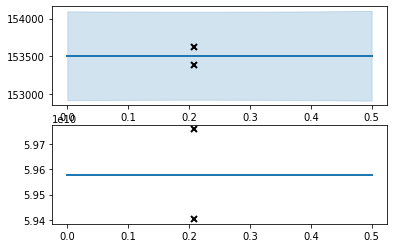

C = [0.20851855]
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 23460421632.0000 - mae: 213196.7656 - mse: 112508960768.0000 - val_loss: 13439859712.0000 - val_mae: 158945.2031 - val_mse: 64453296128.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 12816059392.0000 - mae: 163678.3594 - mse: 61461659648.0000 - val_loss: 12681723904.0000 - val_mae: 156571.8125 - val_mse: 60817436672.0000
Epoch 3/6
517/517 [==============================] - 1s 1ms/step - loss: 12186105856.0000 - mae: 160312.9531 - mse: 58440613888.0000 - val_loss: 11242442752.0000 - val_mae: 153555.3906 - val_mse: 53915054080.0000
Epoch 4/6
517/517 [==============================] - 1s 1ms/step - loss: 11856741376.0000 - mae: 158676.1406 - mse: 56861052928.0000 - val_loss: 11668549632.0000 - val_mae: 159484.5781 - val_mse: 55958536192.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 11930272768.0000 - mae: 158798.0312 - mse: 57213640704.00

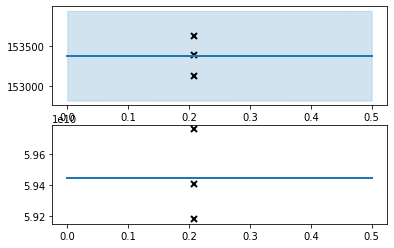

C = [0.20853644]
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 22844307456.0000 - mae: 210250.5469 - mse: 109544857600.0000 - val_loss: 13149926400.0000 - val_mae: 158498.2344 - val_mse: 63057424384.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 12743697408.0000 - mae: 163837.8125 - mse: 61109374976.0000 - val_loss: 12816504832.0000 - val_mae: 157375.5938 - val_mse: 61458530304.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 12285094912.0000 - mae: 161505.0781 - mse: 58910248960.0000 - val_loss: 11396934656.0000 - val_mae: 154632.0781 - val_mse: 54651269120.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 11946790912.0000 - mae: 159961.8281 - mse: 57287950336.0000 - val_loss: 11837512704.0000 - val_mae: 161287.0781 - val_mse: 56763949056.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 12073017344.0000 - mae: 160534.0469 - mse: 57893298176.00

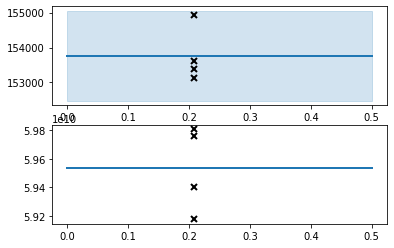

C = [0.41539252]
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 175728656384.0000 - mae: 538371.7500 - mse: 423040876544.0000 - val_loss: 178637209600.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 175728541696.0000 - mae: 538371.4375 - mse: 423040516096.0000 - val_loss: 178637209600.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 175728558080.0000 - mae: 538371.7500 - mse: 423040811008.0000 - val_loss: 178637209600.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 175728492544.0000 - mae: 538371.5625 - mse: 423040581632.0000 - val_loss: 178637209600.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517 [==============================] - 1s 1ms/step - loss: 175728525312.0000 - mae: 538371.4375 - mse

InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/triangular_solve/MatrixTriangularSolve' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2768, in run_cell
      result = self._run_cell(
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2814, in _run_cell
      return runner(coro)
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3012, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3251, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_3944382/16118900.py", line 36, in <module>
      GP.optimizeKernel()             ## Optimize kernel hyperparameters
    File "/home/mtm/MOOEasyTool/models/GaussianProcess.py", line 52, in optimizeKernel
      self.multiGPR.optimizeKernel()
    File "/home/mtm/MOOEasyTool/models/GaussianProcess.py", line 457, in optimizeKernel
      self.opt.minimize(
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/gpflow/optimizers/scipy.py", line 95, in minimize
      return scipy.optimize.minimize(
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/scipy/optimize/_minimize.py", line 681, in minimize
      res = _minimize_lbfgsb(fun, x0, args, jac, bounds,
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/scipy/optimize/_lbfgsb_py.py", line 308, in _minimize_lbfgsb
      sf = _prepare_scalar_function(fun, x0, jac=jac, args=args, epsilon=eps,
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/scipy/optimize/_optimize.py", line 263, in _prepare_scalar_function
      sf = ScalarFunction(fun, x0, args, grad, hess,
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py", line 158, in __init__
      self._update_fun()
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py", line 251, in _update_fun
      self._update_fun_impl()
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py", line 155, in update_fun
      self.f = fun_wrapped(self.x)
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py", line 137, in fun_wrapped
      fx = fun(np.copy(x), *args)
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/scipy/optimize/_optimize.py", line 76, in __call__
      self._compute_if_needed(x, *args)
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/scipy/optimize/_optimize.py", line 70, in _compute_if_needed
      fg = self.fun(x, *args)
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/gpflow/optimizers/scipy.py", line 137, in _eval
      loss, grad = _tf_eval(tf.convert_to_tensor(x))
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/gpflow/optimizers/scipy.py", line 119, in _tf_eval
      if first_call:
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/gpflow/optimizers/scipy.py", line 121, in _tf_eval
      loss, grads = _compute_loss_and_gradients(
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/gpflow/optimizers/scipy.py", line 225, in _compute_loss_and_gradients
      grads = tape.gradient(loss, variables, unconnected_gradients=unconnected_gradients)
Node: 'gradient_tape/triangular_solve/MatrixTriangularSolve'
Input matrix is not invertible.
	 [[{{node gradient_tape/triangular_solve/MatrixTriangularSolve}}]] [Op:__inference__tf_eval_206706]

In [6]:
savename = "MOONNHouses"

### GPs Initialization
GP = GaussianProcess(O, C, d, lowerBounds, upperBounds, noise_variance=2e-6)

#### Initial samples, at least 1
for l in range(initial_iter):
    ## Get random evaluation point
    while True:
        x_rand = np.random.uniform(lowerBounds[0], upperBounds[0], d)
        if GP.X is None or not x_rand in GP.X:
            break
    ## EVALUATION OF THE OUTSIDE FUNCTION
    
    y_rand = evaluation(x_rand)
    GP.addSample(x_rand,y_rand)

GP.updateGP()
GP.optimizeKernel()
if False:
    GP.plotSamples()

for l in range(total_iter):

    ## For all acq functions but usemo
    #x_best, acq_best = mes_acq(GP)
    ## For usemo
    x_best, acq_best = usemo_acq(GP, function = "ei", showplots = False)

    ## EVALUATION OF THE OUTSIDE FUNCTION
    y_best = evaluation(x_best)

    ## UPDATE
    GP.addSample(x_best,y_best)     ## Add new sample to the model
    GP.updateGP()                   ## Update data on the GP regressor
    GP.optimizeKernel()             ## Optimize kernel hyperparameters

    print("Iteration=", l, " x_best=", x_best, "y=", y_best)
    GP.plot()
    

## Evaluate results

As you are doing a real world experiment you do not have access to the real pareto front, then you fo noy hsbr yhr metrics as before (I removed them).

What you should evaluate is the results in terms of the best *y* possible. You have the data below, but you may do a pandas dataframe to store it cleaner when it is computed in the previous section.

GP.X === samples where the function was evaluated

GP.Y === results of those evaluations

In [ ]:
GP.X, GP.Y

In [ ]:
plt.scatter(-GP.Y[:,0],-GP.Y[:,1])

In [ ]:
GP.Y

In [11]:
results = []
for c in np.linspace(0,0.2,100):
    print("########################################")
    print("Iteration: ", len(results) + 1)
    results.append([c, MOOnnHousesRegression(c)])
    


########################################
Iteration:  1
C = 0.0
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 203464.4531 - mae: 203464.4531 - mse: 118533816320.0000 - val_loss: 160074.2188 - val_mae: 160074.2188 - val_mse: 69743034368.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 158259.0781 - mae: 158259.0781 - mse: 67517026304.0000 - val_loss: 153197.8438 - val_mae: 153197.8438 - val_mse: 61622104064.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 155253.0938 - mae: 155253.0938 - mse: 63382835200.0000 - val_loss: 153978.4219 - val_mae: 153978.4219 - val_mse: 63718019072.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 154567.0625 - mae: 154567.0625 - mse: 62259765248.0000 - val_loss: 150757.5000 - val_mae: 150757.5000 - val_mse: 58178711552.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 154180.7656 - mae: 154180.7656 - mse: 61396533248.0

517/517 [==============================] - 1s 2ms/step - loss: 5128303616.0000 - mae: 538371.7500 - mse: 423040876544.0000 - val_loss: 5213185536.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 5128301056.0000 - mae: 538371.4375 - mse: 423040516096.0000 - val_loss: 5213185536.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 5128300544.0000 - mae: 538371.7500 - mse: 423040811008.0000 - val_loss: 5213185536.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 5128304640.0000 - mae: 538371.5625 - mse: 423040581632.0000 - val_loss: 5213185536.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 5128307200.0000 - mae: 538371.4375 - mse: 423040942080.0000 - val_loss: 5213185536.00

517/517 [==============================] - 1s 2ms/step - loss: 2754905344.0000 - mae: 214140.1094 - mse: 113631076352.0000 - val_loss: 1570118528.0000 - val_mae: 159184.3750 - val_mse: 64760836096.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 1491298688.0000 - mae: 163518.2031 - mse: 61509365760.0000 - val_loss: 1464684672.0000 - val_mae: 156369.2812 - val_mse: 60411777024.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 1425438848.0000 - mae: 160798.5781 - mse: 58792718336.0000 - val_loss: 1311344768.0000 - val_mae: 153896.5938 - val_mse: 54086623232.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 1384643200.0000 - mae: 158974.4219 - mse: 57109942272.0000 - val_loss: 1355450112.0000 - val_mae: 159357.7031 - val_mse: 55905738752.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 1387209472.0000 - mae: 158665.7188 - mse: 57215827968.0000 - val_loss: 1481620864.0000 - val

517/517 [==============================] - 1s 2ms/step - loss: 4598681088.0000 - mae: 228011.7500 - mse: 126457364480.0000 - val_loss: 2342172928.0000 - val_mae: 159274.1250 - val_mse: 64405397504.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 2251576064.0000 - mae: 164727.3438 - mse: 61913767936.0000 - val_loss: 2241164544.0000 - val_mae: 158120.8438 - val_mse: 61627682816.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 2169925120.0000 - mae: 162378.1875 - mse: 59668496384.0000 - val_loss: 1985244544.0000 - val_mae: 154645.5000 - val_mse: 54589980672.0000
Epoch 4/6
517/517 [==============================] - 1s 1ms/step - loss: 2101024256.0000 - mae: 160455.1875 - mse: 57773789184.0000 - val_loss: 2052339200.0000 - val_mae: 160086.2812 - val_mse: 56434921472.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 2109266432.0000 - mae: 160417.8906 - mse: 58000412672.0000 - val_loss: 2282691328.0000 - val

517/517 [==============================] - 1s 2ms/step - loss: 5350306304.0000 - mae: 210979.6719 - mse: 110345699328.0000 - val_loss: 3037353472.0000 - val_mae: 157919.2812 - val_mse: 62642163712.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 2953971456.0000 - mae: 163413.9219 - mse: 60922302464.0000 - val_loss: 2957496320.0000 - val_mae: 156829.3438 - val_mse: 60995137536.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 2838334464.0000 - mae: 160884.9531 - mse: 58537349120.0000 - val_loss: 2638423040.0000 - val_mae: 154109.5781 - val_mse: 54414303232.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 2774371584.0000 - mae: 159747.6875 - mse: 57218076672.0000 - val_loss: 2745541888.0000 - val_mae: 160799.5469 - val_mse: 56623501312.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 2797827072.0000 - mae: 160204.9688 - mse: 57701892096.0000 - val_loss: 3026648832.0000 - val

517/517 [==============================] - 1s 2ms/step - loss: 6903173120.0000 - mae: 214345.8125 - mse: 113898790912.0000 - val_loss: 3978400512.0000 - val_mae: 159458.9219 - val_mse: 65640968192.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 3734518784.0000 - mae: 163553.2969 - mse: 61616840704.0000 - val_loss: 3688961536.0000 - val_mae: 156245.5312 - val_mse: 60865273856.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 3539050240.0000 - mae: 159881.3594 - mse: 58391654400.0000 - val_loss: 3255572736.0000 - val_mae: 152639.9844 - val_mse: 53714432000.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 3439376128.0000 - mae: 158217.8438 - mse: 56747122688.0000 - val_loss: 3380067072.0000 - val_mae: 158530.9219 - val_mse: 55768477696.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 3457082112.0000 - mae: 158350.5156 - mse: 57039241216.0000 - val_loss: 3736999168.0000 - val

517/517 [==============================] - 1s 2ms/step - loss: 8038277632.0000 - mae: 211125.5000 - mse: 110523482112.0000 - val_loss: 4626675712.0000 - val_mae: 159210.8125 - val_mse: 63614586880.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 4482736128.0000 - mae: 164376.2656 - mse: 61635366912.0000 - val_loss: 4493740544.0000 - val_mae: 158067.4062 - val_mse: 61786783744.0000
Epoch 3/6
517/517 [==============================] - 1s 1ms/step - loss: 4291060480.0000 - mae: 161485.3438 - mse: 58999894016.0000 - val_loss: 3957051904.0000 - val_mae: 154356.1250 - val_mse: 54407348224.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 4165700096.0000 - mae: 159592.2031 - mse: 57276231680.0000 - val_loss: 4085716480.0000 - val_mae: 160268.1719 - val_mse: 56176402432.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 4178443520.0000 - mae: 159345.4062 - mse: 57451413504.0000 - val_loss: 4542275584.0000 - val

517/517 [==============================] - 1s 2ms/step - loss: 9727687680.0000 - mae: 215192.8750 - mse: 114645213184.0000 - val_loss: 5574467072.0000 - val_mae: 159863.1719 - val_mse: 65697185792.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 5216500736.0000 - mae: 163745.7812 - mse: 61478219776.0000 - val_loss: 5149114880.0000 - val_mae: 156614.4062 - val_mse: 60684148736.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 4968006656.0000 - mae: 160913.5156 - mse: 58549616640.0000 - val_loss: 4602130944.0000 - val_mae: 154083.0938 - val_mse: 54237593600.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 4855234048.0000 - mae: 159579.8594 - mse: 57220509696.0000 - val_loss: 4831575040.0000 - val_mae: 160400.0000 - val_mse: 56941662208.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 4888949248.0000 - mae: 159921.2656 - mse: 57617862656.0000 - val_loss: 5241127424.0000 - val

517/517 [==============================] - 1s 2ms/step - loss: 10908029952.0000 - mae: 213011.0938 - mse: 112486801408.0000 - val_loss: 6238558720.0000 - val_mae: 158861.3281 - val_mse: 64333484032.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 5944922112.0000 - mae: 163254.7188 - mse: 61305348096.0000 - val_loss: 5856491520.0000 - val_mae: 155834.4531 - val_mse: 60393467904.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 5652471296.0000 - mae: 159854.8125 - mse: 58289446912.0000 - val_loss: 5219564544.0000 - val_mae: 153017.1406 - val_mse: 53825187840.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 5490666496.0000 - mae: 158060.8281 - mse: 56620883968.0000 - val_loss: 5395158528.0000 - val_mae: 158517.0938 - val_mse: 55635939328.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 5526517760.0000 - mae: 158287.4844 - mse: 56990625792.0000 - val_loss: 5936156672.0000 - va

517/517 [==============================] - 1s 2ms/step - loss: 12253012992.0000 - mae: 212905.4844 - mse: 112317349888.0000 - val_loss: 6948024320.0000 - val_mae: 159151.2500 - val_mse: 63688785920.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 6695422976.0000 - mae: 163979.8750 - mse: 61373231104.0000 - val_loss: 6651247104.0000 - val_mae: 157306.7031 - val_mse: 60968312832.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 6402750464.0000 - mae: 161163.1406 - mse: 58690412544.0000 - val_loss: 5933779968.0000 - val_mae: 154150.5312 - val_mse: 54391566336.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 6249965568.0000 - mae: 159657.5938 - mse: 57289920512.0000 - val_loss: 6153960960.0000 - val_mae: 160312.2500 - val_mse: 56409841664.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 6280759808.0000 - mae: 159613.1250 - mse: 57572167680.0000 - val_loss: 6726080512.0000 - va

517/517 [==============================] - 1s 2ms/step - loss: 13715086336.0000 - mae: 213614.6094 - mse: 113147625472.0000 - val_loss: 8010769408.0000 - val_mae: 159910.3438 - val_mse: 66087489536.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 7551824896.0000 - mae: 164588.6094 - mse: 62301171712.0000 - val_loss: 7428799488.0000 - val_mae: 157372.1875 - val_mse: 61286313984.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 7145202688.0000 - mae: 160594.8438 - mse: 58946568192.0000 - val_loss: 6499905024.0000 - val_mae: 152822.8281 - val_mse: 53622956032.0000
Epoch 4/6
517/517 [==============================] - 1s 1ms/step - loss: 6901537792.0000 - mae: 158295.9062 - mse: 56936361984.0000 - val_loss: 6767353344.0000 - val_mae: 159351.8906 - val_mse: 55829364736.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 6928637440.0000 - mae: 158351.1875 - mse: 57159962624.0000 - val_loss: 7389809664.0000 - va

517/517 [==============================] - 1s 2ms/step - loss: 14716306432.0000 - mae: 210967.3750 - mse: 110370750464.0000 - val_loss: 8457069568.0000 - val_mae: 158068.0312 - val_mse: 63426830336.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 8158063104.0000 - mae: 163546.7344 - mse: 61184233472.0000 - val_loss: 8220731392.0000 - val_mae: 157762.7812 - val_mse: 61654302720.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 7824690176.0000 - mae: 161111.3750 - mse: 58683998208.0000 - val_loss: 7241298944.0000 - val_mae: 154166.6875 - val_mse: 54308573184.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 7643740160.0000 - mae: 159863.0312 - mse: 57326850048.0000 - val_loss: 7618327040.0000 - val_mae: 162450.5156 - val_mse: 57136214016.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 7714467840.0000 - mae: 160406.2188 - mse: 57857265664.0000 - val_loss: 8437789696.0000 - va

517/517 [==============================] - 1s 2ms/step - loss: 16603569152.0000 - mae: 214865.1719 - mse: 114148098048.0000 - val_loss: 9433883648.0000 - val_mae: 159941.5938 - val_mse: 64856838144.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 8957862912.0000 - mae: 163939.6719 - mse: 61584146432.0000 - val_loss: 8846519296.0000 - val_mae: 156867.5938 - val_mse: 60818731008.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 8524042240.0000 - mae: 160884.2656 - mse: 58601672704.0000 - val_loss: 7878939648.0000 - val_mae: 154286.0625 - val_mse: 54166663168.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 8329743872.0000 - mae: 159692.2031 - mse: 57265860608.0000 - val_loss: 8248452608.0000 - val_mae: 160775.4531 - val_mse: 56707031040.0000
Epoch 5/6
517/517 [==============================] - 1s 1ms/step - loss: 8385125888.0000 - mae: 160033.5312 - mse: 57646653440.0000 - val_loss: 9021385728.0000 - va

517/517 [==============================] - 2s 2ms/step - loss: 17596856320.0000 - mae: 212120.2812 - mse: 111671083008.0000 - val_loss: 10134100992.0000 - val_mae: 158631.5156 - val_mse: 64311578624.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 9711065088.0000 - mae: 163842.4219 - mse: 61626871808.0000 - val_loss: 9678577664.0000 - val_mae: 157500.0781 - val_mse: 61420736512.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 9219861504.0000 - mae: 160386.3594 - mse: 58509606912.0000 - val_loss: 8458695168.0000 - val_mae: 152691.6250 - val_mse: 53679214592.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 8945822720.0000 - mae: 158441.0781 - mse: 56770596864.0000 - val_loss: 8847795200.0000 - val_mae: 159553.8438 - val_mse: 56148447232.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 9002326016.0000 - mae: 158571.8750 - mse: 57129140224.0000 - val_loss: 9694705664.0000 - v

517/517 [==============================] - 1s 2ms/step - loss: 19152721920.0000 - mae: 213318.1094 - mse: 112862986240.0000 - val_loss: 10922970112.0000 - val_mae: 159002.6875 - val_mse: 64366555136.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 10468905984.0000 - mae: 164188.7344 - mse: 61690802176.0000 - val_loss: 10333088768.0000 - val_mae: 157183.3281 - val_mse: 60890488832.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 9987034112.0000 - mae: 161344.0156 - mse: 58851221504.0000 - val_loss: 9191591936.0000 - val_mae: 154203.9844 - val_mse: 54163836928.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 9736044544.0000 - mae: 159866.2812 - mse: 57372184576.0000 - val_loss: 9630097408.0000 - val_mae: 160343.8281 - val_mse: 56747859968.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 9795244032.0000 - mae: 159980.5156 - mse: 57721049088.0000 - val_loss: 10573608960.0000 

517/517 [==============================] - 1s 2ms/step - loss: 20481961984.0000 - mae: 213207.5000 - mse: 112649601024.0000 - val_loss: 11707585536.0000 - val_mae: 158867.0781 - val_mse: 64390836224.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 11200574464.0000 - mae: 164078.8281 - mse: 61602275328.0000 - val_loss: 11138824192.0000 - val_mae: 157450.8906 - val_mse: 61262663680.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 10743260160.0000 - mae: 161474.3594 - mse: 59087032320.0000 - val_loss: 9878329344.0000 - val_mae: 154695.4688 - val_mse: 54329962496.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 10443446272.0000 - mae: 159941.8125 - mse: 57438060544.0000 - val_loss: 10225551360.0000 - val_mae: 160141.3281 - val_mse: 56239652864.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 10516121600.0000 - mae: 160164.4844 - mse: 57837780992.0000 - val_loss: 11382599680.0

517/517 [==============================] - 1s 2ms/step - loss: 21295826944.0000 - mae: 210461.9688 - mse: 109805486080.0000 - val_loss: 12391283712.0000 - val_mae: 159013.8281 - val_mse: 63891730432.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 11893594112.0000 - mae: 164137.4688 - mse: 61325484032.0000 - val_loss: 11970918400.0000 - val_mae: 157735.3906 - val_mse: 61724233728.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 11413767168.0000 - mae: 161105.1094 - mse: 58851409920.0000 - val_loss: 10526532608.0000 - val_mae: 153437.6406 - val_mse: 54276644864.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 11074850816.0000 - mae: 159184.9219 - mse: 57103900672.0000 - val_loss: 10957591552.0000 - val_mae: 162109.9219 - val_mse: 56499245056.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 11133867008.0000 - mae: 159094.0938 - mse: 57408135168.0000 - val_loss: 12097522688.

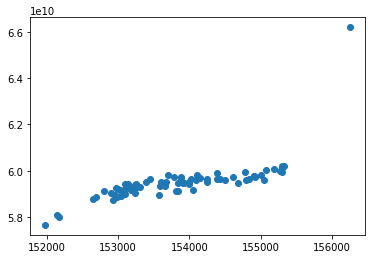

In [13]:
evs = [row[0] for row in results if row[1][0] < 500000]
mae = [row[1][0] for row in results if row[1][0] < 500000]
mse = [row[1][1] for row in results if row[1][0] < 500000]
plt.scatter(mae, mse)

In [14]:
len(mae)

81

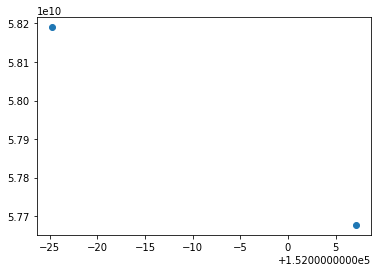

In [10]:
from utils.calc_pareto import get_pareto_undominated_by

front = get_pareto_undominated_by(np.array([[x[0],x[1]] for x in zip(mae,mse)]))

plt.scatter(front[:,0],front[:,1])

In [38]:
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

data = pd.read_csv("kc_house_data.csv")
X = data.drop(["price", "id", "date"], axis=1)
y = data["price"]

#X_used, _, y_used, _ = train_test_split(X, y, test_size=0.9, random_state=42)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42)

test_results = []
val_results = []

for model_path in os.listdir('./Checkpoints'):
    if model_path.count("_") == 1 and "data" in model_path:
        
        checkpoint_path = './Checkpoints/' + model_path
        checkpoint_path = checkpoint_path.replace(".data-00000-of-00001", "")
        
        model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(18, 1)),
      tf.keras.layers.Dense(500, activation='relu'),
      tf.keras.layers.Dense(500, activation='relu'),
      tf.keras.layers.Dense(1, activation='relu')
    ])
        model.load_weights(checkpoint_path)
    
        y_pred_val = model.predict(X_val)
        y_pred = model.predict(X_test)
        
        val_results.append([mean_absolute_error(y_val, y_pred_val), mean_squared_error(y_val, y_pred_val)])
        test_results.append([mean_absolute_error(y_test, y_pred), mean_squared_error(y_test, y_pred)])

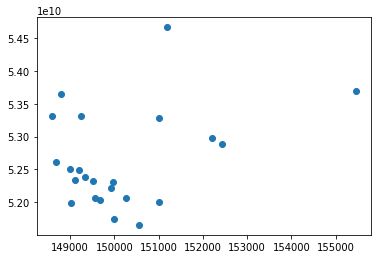

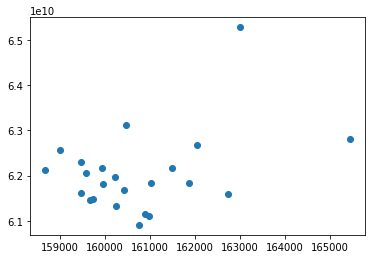

In [41]:
plt.scatter(np.array(val_results)[:,0],np.array(val_results)[:,1])
plt.show()
plt.scatter(np.array(test_results)[:,0],np.array(test_results)[:,1])

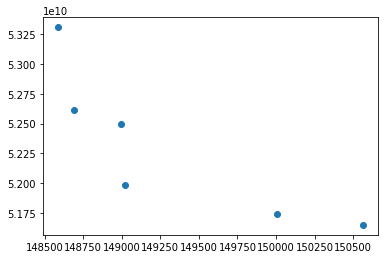

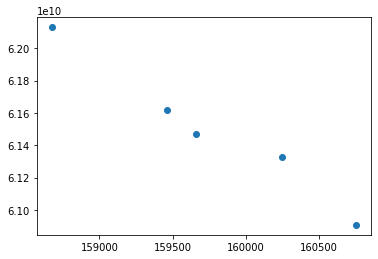

In [46]:
from utils.calc_pareto import get_pareto_undominated_by

val_front = get_pareto_undominated_by(np.array(val_results))
test_front = get_pareto_undominated_by(np.array(test_results))

plt.scatter(val_front[:,0],val_front[:,1])
plt.show()
plt.scatter(test_front[:,0],test_front[:,1])

In [5]:
mae

[542668.6600411241,
 158561.60495737664,
 542668.6600411241,
 153747.38450240827,
 151261.23043662182,
 154111.52223269362,
 149556.92762861977,
 158932.8808901645,
 152480.40333169122,
 152758.2764254198,
 150204.70931770475,
 156674.5767782942,
 153009.96851439343,
 164565.18173834818,
 163059.0111217015]

In [49]:
i = 0
for model_path in os.listdir('./Checkpoints'):
    if model_path.count("_") == 2 and "data" in model_path:
        i = i + 1

In [143]:
test_results_2 = []
val_results_2 = []
models = []

for model_path in os.listdir('./Checkpoints'):
    if model_path.count("_") == 2 and "data" in model_path:
        
        checkpoint_path = './Checkpoints/' + model_path
        checkpoint_path = checkpoint_path.replace(".data-00000-of-00001", "")
        
        model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(18, 1)),
      tf.keras.layers.Dense(500, activation='relu'),
      tf.keras.layers.Dense(500, activation='relu'),
      tf.keras.layers.Dense(1, activation='relu')
    ])
        model.load_weights(checkpoint_path)
    
        y_pred_val = model.predict(X_val)
        y_pred = model.predict(X_test)
        
        models.append(model)
        
        val_results_2.append([mean_absolute_error(y_val, y_pred_val), mean_squared_error(y_val, y_pred_val)])
        test_results_2.append([mean_absolute_error(y_test, y_pred), mean_squared_error(y_test, y_pred)])

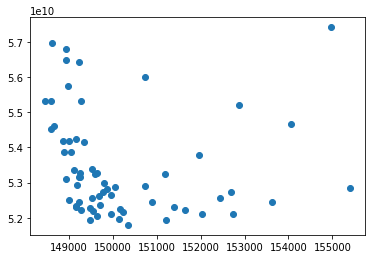

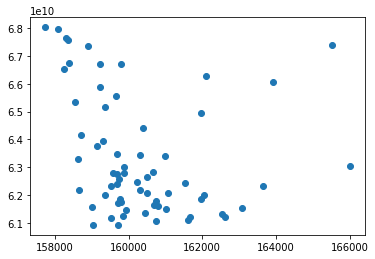

In [146]:
plt.scatter(np.array(val_results_2)[:,0],np.array(val_results_2)[:,1])
plt.show()
plt.scatter(np.array(test_results_2)[:,0],np.array(test_results_2)[:,1])

In [117]:
val_front_2_old = np.array([[1.49003720e+05, 5.24912773e+10],
       [1.48867111e+05, 5.41791606e+10],
       [1.48468350e+05, 5.53161187e+10],
       [1.49267449e+05, 5.22063704e+10],
       [1.49480191e+05, 5.19453190e+10],
       [1.48603847e+05, 5.45343308e+10],
       [1.48940001e+05, 5.31148215e+10],
       [1.50348893e+05, 5.17947302e+10],
       [1.48893334e+05, 5.38597505e+10],
       [1.49239384e+05, 5.24602185e+10]])

In [137]:
val_results_2_sci = np.array([[np.format_float_scientific(x[0], precision=8), np.format_float_scientific(x[1], precision=8)] for x in val_results_2])
val_results_2_sci = val_results_2_sci.astype("float")

In [139]:
[np.where(np.all(val_results_2_sci == x, axis=1)) for x in val_front_2_old]

[(array([9]),),
 (array([11]),),
 (array([14]),),
 (array([16]),),
 (array([18]),),
 (array([31]),),
 (array([48]),),
 (array([50]),),
 (array([51]),),
 (array([63]),)]

In [140]:
pfindexes_old = [np.where(np.all(val_results_2_sci == x, axis=1))[0][0] for x in np.array(val_front_2_old)]

test_front_2_from_val_old = [test_results_2[i] for i in pfindexes_old]
test_front_2_from_val_old = np.array(test_front_2_from_val_old)
test_front_2_from_val_old

array([[1.59699368e+05, 6.17298701e+10],
       [1.59665266e+05, 6.55502080e+10],
       [1.58369847e+05, 6.67456713e+10],
       [1.59934197e+05, 6.14457760e+10],
       [1.59856143e+05, 6.12568757e+10],
       [1.58529003e+05, 6.53293210e+10],
       [1.58649100e+05, 6.21957607e+10],
       [1.60810188e+05, 6.16031431e+10],
       [1.59308408e+05, 6.39530471e+10],
       [1.59345156e+05, 6.19949751e+10]])

In [149]:
pfindexes = [np.where(np.all(val_results_2 == x, axis=1))[0][0] for x in np.array(val_front_2)]

test_front_2_from_val = [test_results_2[i] for i in pfindexes]
test_front_2_from_val = np.array(test_front_2_from_val)
test_front_2_from_val

array([[1.59699368e+05, 6.17298701e+10],
       [1.59665266e+05, 6.55502080e+10],
       [1.58369847e+05, 6.67456713e+10],
       [1.59934197e+05, 6.14457760e+10],
       [1.59856143e+05, 6.12568757e+10],
       [1.58529003e+05, 6.53293210e+10],
       [1.60688589e+05, 6.16288945e+10],
       [1.61622254e+05, 6.11119687e+10],
       [1.63067768e+05, 6.15193418e+10],
       [1.60810188e+05, 6.16031431e+10]])

In [114]:
val_front_2

array([[1.48468350e+05, 5.53161187e+10],
       [1.49267449e+05, 5.22063704e+10],
       [1.49480191e+05, 5.19453190e+10],
       [1.48511382e+05, 5.23840105e+10],
       [1.49163327e+05, 5.23073899e+10],
       [1.50348893e+05, 5.17947302e+10]])

In [152]:
test_front_2_from_val

array([[1.59699368e+05, 6.17298701e+10],
       [1.59665266e+05, 6.55502080e+10],
       [1.58369847e+05, 6.67456713e+10],
       [1.59934197e+05, 6.14457760e+10],
       [1.59856143e+05, 6.12568757e+10],
       [1.58529003e+05, 6.53293210e+10],
       [1.60688589e+05, 6.16288945e+10],
       [1.61622254e+05, 6.11119687e+10],
       [1.63067768e+05, 6.15193418e+10],
       [1.60810188e+05, 6.16031431e+10]])

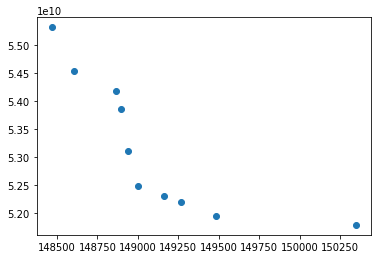

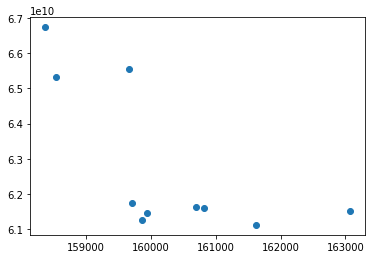

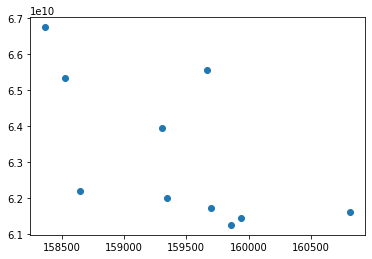

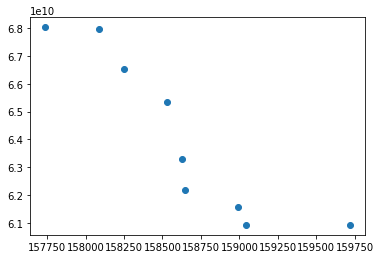

In [150]:
from utils.calc_pareto import get_pareto_undominated_by

val_front_2 = get_pareto_undominated_by(np.array(val_results_2))
test_front_2 = get_pareto_undominated_by(np.array(test_results_2))

plt.scatter(val_front_2[:,0],val_front_2[:,1])
plt.show()
plt.scatter(test_front_2_from_val[:,0],test_front_2_from_val[:,1])
plt.show()
plt.scatter(test_front_2_from_val_old[:,0],test_front_2_from_val_old[:,1])
plt.show()
plt.scatter(test_front_2[:,0],test_front_2[:,1])

In [79]:
test_front_2

array([[1.58529003e+05, 6.53293210e+10],
       [1.58992946e+05, 6.15652101e+10],
       [1.58627943e+05, 6.32797702e+10],
       [1.58649100e+05, 6.21957607e+10],
       [1.59718334e+05, 6.09256685e+10],
       [1.58252215e+05, 6.65150386e+10]])

In [145]:
val_results_2.remove([148511.38213245373, 52384010455.63921])

In [86]:
y = np.array([[0.76760563, 0.76011158],
       [0.72552783, 0.87866109],
       [0.72552783, 0.87866109],
       [0.74202665, 0.85448629],
       [0.72433679, 0.87587169],
       [0.72862163, 0.86750349],
       [0.75433276, 0.80939098],
       [0.72397661, 0.86331939],
       [0.801509  , 0.64202696],
       [0.72398018, 0.88284519],
       [0.74222586, 0.84332868],
       [0.74495798, 0.82426778],
       [0.72159091, 0.88563459],
       [0.70463529, 0.91166899],
       [0.73012796, 0.87540679],
       [0.75281873, 0.80706648],
       [0.73914807, 0.84704788],
       [0.73954061, 0.83821478],
       [0.75485542, 0.81311018],
       [0.7001071 , 0.91166899],
       [0.73851732, 0.85216179],
       [0.74695762, 0.82752208],
       [0.69088369, 0.91957229],
       [0.7192849 , 0.87912599],
       [0.73819055, 0.85727569],
       [0.75639358, 0.81125058],
       [0.73064894, 0.86889819],
       [0.72997265, 0.86843329],
       [0.76048171, 0.79265458],
       [0.71149595, 0.89772199],
       [0.74346405, 0.84611808],
       [0.72120519, 0.87912599],
       [0.75934888, 0.80241748],
       [0.75162267, 0.80753138],
       [0.75580886, 0.80148768],
       [0.74372686, 0.84053928],
       [0.76451613, 0.77126918],
       [0.78018109, 0.72105997],
       [0.72615385, 0.87773129],
       [0.72274972, 0.88470479],
       [0.74883917, 0.82473268]])

In [88]:
from utils.calc_pareto import get_pareto_undominated_by

get_pareto_undominated_by(y)

array([[0.76760563, 0.76011158],
       [0.72397661, 0.86331939],
       [0.801509  , 0.64202696],
       [0.74495798, 0.82426778],
       [0.70463529, 0.91166899],
       [0.75281873, 0.80706648],
       [0.73914807, 0.84704788],
       [0.73954061, 0.83821478],
       [0.7001071 , 0.91166899],
       [0.73851732, 0.85216179],
       [0.69088369, 0.91957229],
       [0.7192849 , 0.87912599],
       [0.73819055, 0.85727569],
       [0.76048171, 0.79265458],
       [0.71149595, 0.89772199],
       [0.72120519, 0.87912599],
       [0.75162267, 0.80753138],
       [0.75580886, 0.80148768],
       [0.76451613, 0.77126918],
       [0.78018109, 0.72105997]])